# Figure S4: Stability of decision-making parameters modulation by reward history 
## &
# Figure S9: Stability of model parameters capturing run duration modulation by reward history

## imports and setup

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
from scipy import stats

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


In [3]:
rat_markers = {}
params = {}
sequence = {}


# RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
              'RatF30', 'RatF31', 'RatF32', 'RatF33', 'RatM30', 'RatM31', 'RatM32', 
              'RatF40', 'RatF41', 'RatF42', 'RatM40', 'RatM41', 'RatM42', 'RatM43', 
                'RatF50', 'RatF51', 'RatF52', 'RatM50', 'RatM51', 'RatM52', 'RatM53', 'RatM54']

animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

rat_markers = {}
m, f = 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in animalList if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in animalList if 'F' in x]), start_intensity=80)

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', ]
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', ]
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")
    
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p")
        params[animal, session]     = get_from_pickle(root, animal[0:6], session, name="params.p")

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


# Modified model with early/late αu, γu, μu, σu

In [4]:
# separate the data into time and reward bins for each experimental condition
# distances 
data60IDLE = prepare_data_idle_times(sequence, animalList, dist60)
data90IDLE = prepare_data_idle_times(sequence, animalList, dist90)
data120IDLE = prepare_data_idle_times(sequence, animalList, dist120)

data60RUN = prepare_data_running_times(sequence, animalList, dist60)
data90RUN = prepare_data_running_times(sequence, animalList, dist90)
data120RUN = prepare_data_running_times(sequence, animalList, dist120)

# treadmill speeds
data20IDLE = prepare_data_idle_times(sequence, animalList, TM20)
data10IDLE = prepare_data_idle_times(sequence, animalList, TM10)
data2IDLE = prepare_data_idle_times(sequence, animalList, TM2+TMrev2)
datarev10IDLE = prepare_data_idle_times(sequence, animalList, TMrev10)
datarev20IDLE = prepare_data_idle_times(sequence, animalList, TMrev20)

data20RUN = prepare_data_running_times(sequence, animalList, TM20)
data10RUN = prepare_data_running_times(sequence, animalList, TM10)
data2RUN = prepare_data_running_times(sequence, animalList, TM2+TMrev2)
datarev10RUN = prepare_data_running_times(sequence, animalList, TMrev10)
datarev20RUN = prepare_data_running_times(sequence, animalList, TMrev20)

# all conditions pooled
dataAllIDLE = prepare_data_idle_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)
dataAllRUN = prepare_data_running_times(sequence, animalList, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)


In [5]:
# model interrun
def model_crit(params, *args, robustness_param=1e-20):
    """negative log likelihood function for full model"""
    alpha, theta, gamma, alpha_t, theta_prime, gamma_t, alpha_R, theta_second, gamma_R, alpha_U_late, _, gamma_U_late = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    ALPHA = np.zeros((N_bins, N_avg))
    GAMMA = np.zeros((N_bins, N_avg))
    _theta = theta + theta_prime + theta_second

    for bin in range(N_bins):
        for avg in range(N_avg):
            alpha_U = alpha_R if bin <=2 else alpha_U_late
            gamma_U = gamma_R if bin <=2 else gamma_U_late
        
            ALPHA[bin, avg] = alpha + bin*alpha_t + avg*alpha_U
            GAMMA[bin, avg] = gamma + bin*gamma_t + avg*gamma_U

    for bin in range(N_bins):
        for avg in range(N_avg):
            _alpha = ALPHA[bin, avg] if ALPHA[bin, avg] > 0 else 1e-8
            _gamma = GAMMA[bin, avg]# if GAMMA[bin, avg] > 0 else 1e-8
            try:
                pdf_vals = Wald_pdf(args[0][bin][avg], _alpha, _theta, _gamma)
                ln_pdf_vals = np.log(pdf_vals + robustness_param)
                log_lik_val = ln_pdf_vals.sum()

                n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
                neg_log_lik_val += (-log_lik_val / n)
            except:
                neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val

def modelwald_fit(data, init=[2, 0, .5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  f=model_crit, N_bins=6, N_avg=4, N_params=2,
                  alpha_t_fixed=False, gamma_t_fixed=False,
                  alpha_R_fixed=False, gamma_R_fixed=False,
                  ):
    """fit full model to data"""
    params_init = np.array(init)
    alpha_t_bounds = (None, None) if not alpha_t_fixed else (0, 1e-8)
    gamma_t_bounds = (None, None) if not gamma_t_fixed else (0, 1e-8)
    alpha_R_bounds = (None, None) if not alpha_R_fixed else (0, 1e-8)
    gamma_R_bounds = (None, None) if not gamma_R_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((0, None), (0, 1e-8), (0, None),
                   alpha_t_bounds, (0, 1e-8), gamma_t_bounds,
                   alpha_R_bounds, (0, 1e-8), gamma_R_bounds, 
                   (None, None), (0, 1e-8), (None, None)))
    return res.x, res.fun

modelwald_fit(data60IDLE[animal], f=model_crit)

(array([ 1.47149528e+00,  1.00000000e-08,  9.06503496e-01,  1.41005236e-01,
         1.00000000e-08, -2.64729823e-02, -3.41066504e-03,  1.00000000e-08,
        -2.15394821e-01,  3.60419577e-02,  0.00000000e+00, -2.18971909e-01]),
 51.40190542693572)

In [6]:
# model run 
def modelrun_crit(params, *args, robustness_param=1e-20):
    mu, sigma, mu_prime, sigma_prime, mu_second, sigma_second, mu_late, sigma_late = params
    neg_log_lik_val = 0
    N_bins, N_avg = args[1]
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            mu_u = mu_second if bin <=2 else mu_late
            sigma_u = sigma_second if bin <=2 else sigma_late
            MU[bin, avg] = mu + bin*mu_prime + avg*mu_u
            SIGMA[bin, avg] = sigma + bin*sigma_prime + avg*sigma_u

    for bin in range(N_bins):
        for avg in range(N_avg):
            _mu = MU[bin, avg]# if MU[bin, avg] > 0 else 1e-8
            _sigma = SIGMA[bin, avg] if SIGMA[bin, avg] > 0 else 1e-8

            pdf_vals = stats.cauchy.pdf(args[0][bin][avg], scale=_sigma, loc=_mu,)
            ln_pdf_vals = np.log(pdf_vals + robustness_param)
            log_lik_val = ln_pdf_vals.sum()

            n = len(args[0][bin][avg]) if len(args[0][bin][avg]) > 0 else 1
            neg_log_lik_val += (-log_lik_val / n)
            # neg_log_lik_val += -log_lik_val
            # except:
            #     neg_log_lik_val += 0  # add 0 instead of throwing an error when there is no data in a bin*avg
    return neg_log_lik_val

def modelrun_fit(data, init=[1, 1, 1, 1, 1, 1, 1, 1], f=modelrun_crit,
                 N_bins=6, N_avg=4, N_params=2,
                 mu_t_fixed=False, sigma_t_fixed=False,
                 mu_U_fixed=False, sigma_U_fixed=False):
    params_init = np.array(init)
    mu_t_bounds = (None, None) if not mu_t_fixed else (0, 1e-8)
    sigma_t_bounds = (None, None) if not sigma_t_fixed else (0, 1e-8)
    mu_U_bounds = (None, None) if not mu_U_fixed else (0, 1e-8)
    sigma_U_bounds = (None, None) if not sigma_U_fixed else (0, 1e-8)

    res = minimize(f, params_init, args=(data, [N_bins, N_avg], N_params),
                   bounds=((None, None), (None, None),
                           mu_t_bounds, sigma_t_bounds,
                           mu_U_bounds, sigma_U_bounds, (None, None), (None, None)))
    return res.x, res.fun
modelrun_fit(data60RUN[animal], f=modelrun_crit)

(array([ 0.89080253,  0.07663434,  0.04030205, -0.00139552,  0.03155416,
         0.01574424,  0.03411527,  0.02005444]),
 -2.812336591368701)

In [7]:
# fit all
alpha_t_fixed, gamma_t_fixed, alpha_U_fixed, gamma_U_fixed = False, False, False, False
mu_t_fixed, sigma_t_fixed, mu_U_fixed, sigma_U_fixed = False, False, False, False

alpha, gamma, alpha_t, gamma_t, alpha_U, alpha_U_late, gamma_U, gamma_U_late, lossWald = {}, {}, {}, {}, {}, {}, {}, {}, {}
mu, mu_t, mu_U, mu_U_late, sigma, sigma_t, sigma_U, sigma_U_late, loss = {}, {}, {}, {}, {}, {}, {}, {}, {}

if os.path.exists("picklejar/uearly_ulate.p"):
    alpha, alpha_t, alpha_U, alpha_U_late, gamma, gamma_t, gamma_U, gamma_U_late, \
    mu, mu_t, mu_U, mu_U_late, sigma, sigma_t, sigma_U, sigma_U_late = pickle.load(open("picklejar/uearly_ulate.p", "rb"))
else:
    for animal in animalList:
        print(animal)
        alpha[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        alpha_U_late[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        gamma_U_late[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        lossWald[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}

        mu[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_t[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_U[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        mu_U_late[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        sigma_U_late[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}
        loss[animal] = {"60": 0, "90": 0, "120": 0, "20": 0, "10": 0, "2": 0, "rev10": 0, "rev20": 0}


        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60IDLE, data90IDLE, data120IDLE, data20IDLE, data10IDLE, data2IDLE, datarev10IDLE, datarev20IDLE]):
            (alpha[animal][cond], theta, gamma[animal][cond], \
            alpha_t[animal][cond], thetaprime, gamma_t[animal][cond], \
            alpha_U[animal][cond], thetasecond, gamma_U[animal][cond], \
            alpha_U_late[animal][cond], thetasecond, gamma_U_late[animal][cond]), lossWald[animal][cond] = modelwald_fit(data[animal], f=model_crit)

        for cond, data in zip(["60", "90", "120", "20", "10", "2", "rev10", "rev20"], [data60RUN, data90RUN, data120RUN, data20RUN, data10RUN, data2RUN, datarev10RUN, datarev20RUN]):
            (mu[animal][cond], sigma[animal][cond], \
            mu_t[animal][cond], sigma_t[animal][cond], \
            mu_U[animal][cond], sigma_U[animal][cond], \
            mu_U_late[animal][cond], sigma_U_late[animal][cond]), loss[animal][cond] = modelrun_fit(data[animal], f=modelrun_crit)

    pickle.dump([alpha, alpha_t, alpha_U, alpha_U_late, gamma, gamma_t, gamma_U, gamma_U_late, 
                mu, mu_t, mu_U, mu_U_late, sigma, sigma_t, sigma_U, sigma_U_late], open("picklejar/uearly_ulate.p", "wb"))

In [8]:
alpha, alpha_t, alpha_U, alpha_U_late, gamma, gamma_t, gamma_U, gamma_U_late, mu, mu_t, mu_U, mu_U_late, sigma, sigma_t, sigma_U, sigma_U_late = pickle.load(open("picklejar/uearly_ulate.p", "rb"))

## Fit result

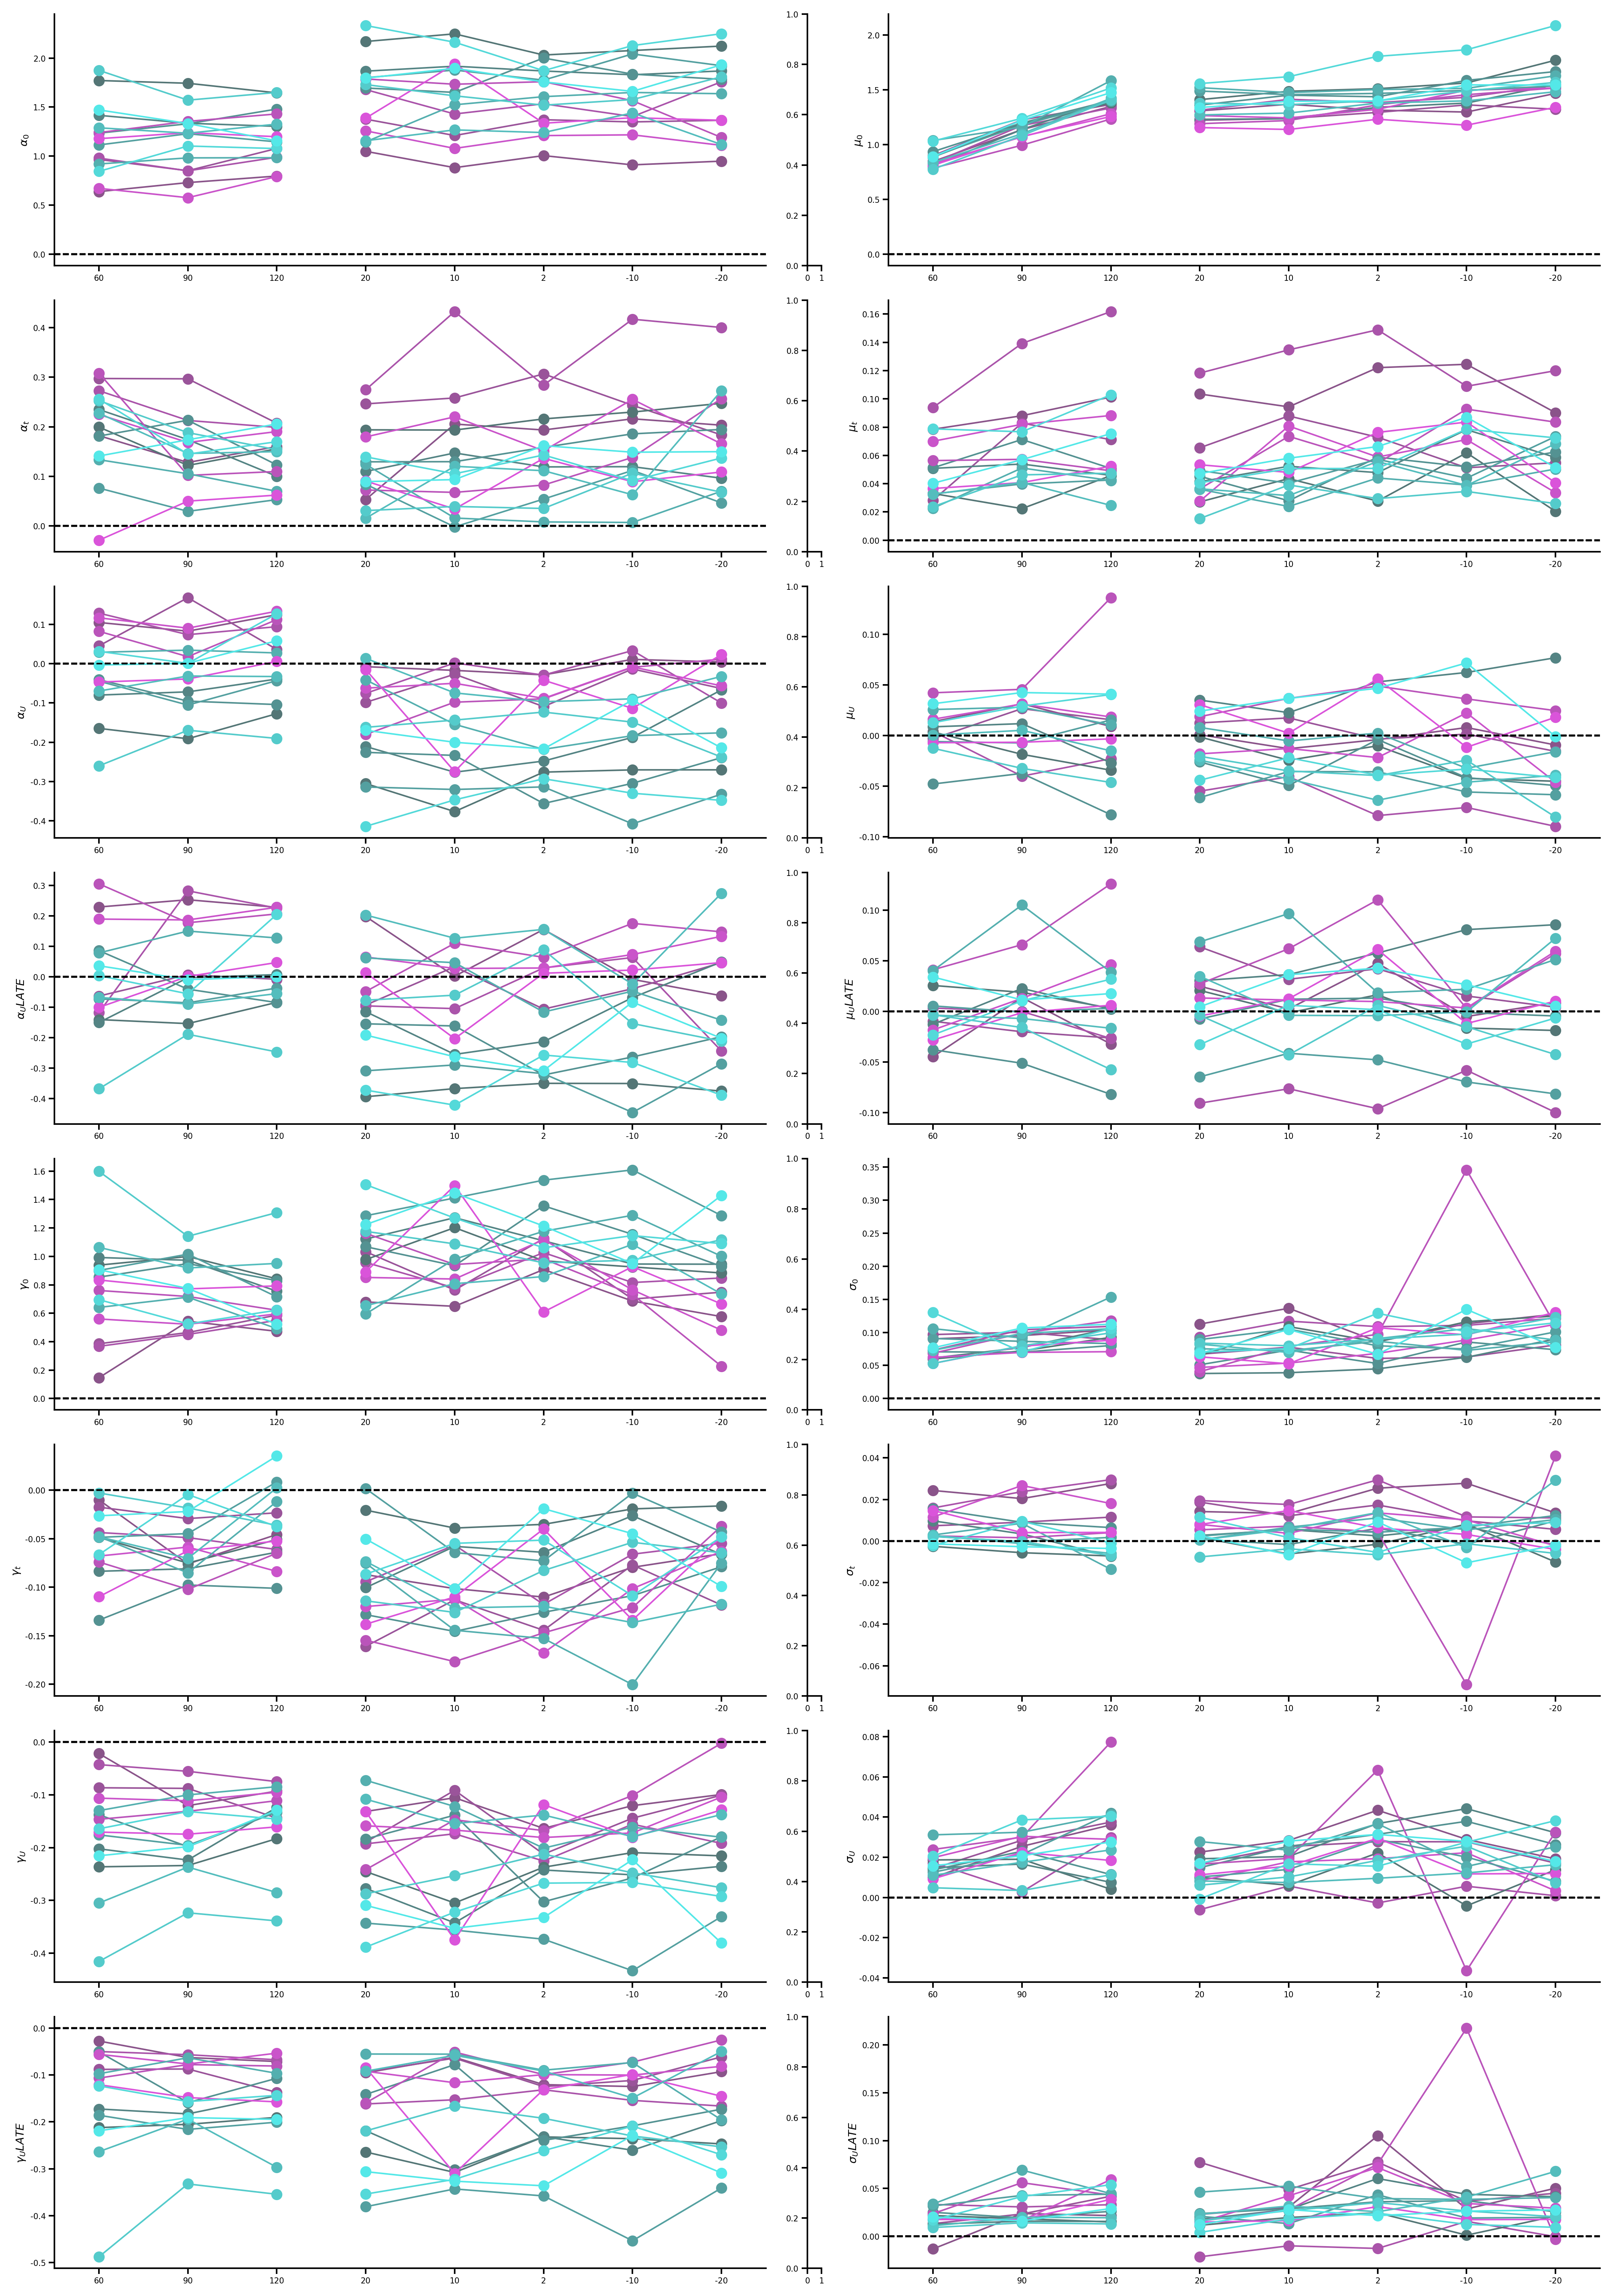

In [9]:
fig, axs = plt.subplots(8, 3, figsize=(14, 20), gridspec_kw={'width_ratios': [5, .1, 5]})
ylabelsIDLE = [r'$\alpha_0$', r"$\alpha_t$", r"$\alpha_U$", r"$\alpha_U LATE$", r'$\gamma_0$', r"$\gamma_t$", r"$\gamma_U$", r"$\gamma_U LATE$"]
ylimsIDLE = [[-.5, 3], [-.1, .65], [-.45, .5], [-.45, .5], [-.2, 1.6], [-.25, .1], [-.35, .1], [-.35, .1]]
ylabelsRUN = [r'$\mu_0$', r"$\mu_t$", r"$\mu_U$", r"$\mu_U LATE$", r'$\sigma_0$', r"$\sigma_t$", r"$\sigma_U$", r"$\sigma_U LATE$"]
ylimsRUN = [[-.2, 2.5], [-.05, .2], [-.15, .15], [-.15, .15], [-.05, .2], [-.05, .05], [-.025, .1], [-.025, .1],]

varsIDLE = [alpha, alpha_t, alpha_U, alpha_U_late,
            gamma, gamma_t, gamma_U, gamma_U_late,]
varsRUN = [mu, mu_t, mu_U, mu_U_late,
           sigma, sigma_t, sigma_U, sigma_U_late,]

for animal in animalList:
    for i, (var, ylabel, ylim) in enumerate(zip(varsIDLE, ylabelsIDLE, ylimsIDLE)):
        # x, y = np.arange(8), [var[animal]["60"], var[animal]["90"], var[animal]["120"], var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]]
        axs[i, 0].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 0].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 0].set_title(f"")
        axs[i, 0].set_xticks(np.arange(8))
        axs[i, 0].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_xlim(-.5, 7.5)
        # axs[i, 0].set_ylim(ylim)
        axs[i, 0].axhline(0, color='black', linestyle='--', linewidth=1)

    for i, (var, ylabel, ylim) in enumerate(zip(varsRUN, ylabelsRUN, ylimsRUN)):
        axs[i, 2].plot([0, 1, 2], [var[animal]["60"], var[animal]["90"], var[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 2].plot([3, 4, 5, 6, 7], [var[animal]["20"], var[animal]["10"], var[animal]["2"], var[animal]["rev10"], var[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1])
        axs[i, 2].set_title(f"")
        axs[i, 2].set_xticks(np.arange(8))
        axs[i, 2].set_xticklabels(["60", "90", "120", "20", "10", "2", "-10", "-20"])
        axs[i, 2].set_ylabel(ylabel)
        axs[i, 2].set_xlim(-.5, 7.5)
        # axs[i, 2].set_ylim(ylim)
        axs[i, 2].axhline(0, color='black', linestyle='--', linewidth=1)

# Figure S4A, S4B, S9A, S9B top correlation early/late

Observed Slope: 1.3630
P-value: 0.0000


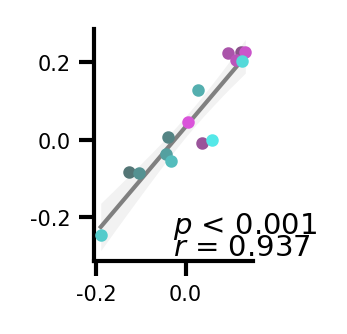

In [10]:
def early_late_regression(early, late, ax=None, plot_indiv=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    x, y = [], []
    for animal in animalList:
        if plot_indiv:
            ax.scatter(early[animal], late[animal], color=rat_markers[animal][0], zorder=10, s=4, marker=rat_markers[animal][1])
        x.append(early[animal])
        y.append(late[animal])

    # fit with np.polyfit
    f = lambda x, *p: np.polyval(p, x)
    p, cov = curve_fit(f, x, y, [1, 1])

    # calculate confidence intervals for fitted line
    xi = np.linspace(np.min(x), np.max(x), 100)
    ps = np.random.multivariate_normal(p, cov, 10000)
    ysample = np.asarray([f(xi, *pi) for pi in ps])
    lower = np.percentile(ysample, 2.5, axis=0)
    upper = np.percentile(ysample, 97.5, axis=0)

    # plot the regression and confidence intervals
    y_fit = np.poly1d(p)(xi)
    ax.plot(xi, y_fit, color='gray', zorder=1)
    ax.fill_between(xi, lower, upper, color='gray', alpha=.1, zorder=0, lw=0)


    # shuffle to get p-value
    observed_slope = p[0]
    num_iterations = 10000
    shuffled_slopes = []

    np.random.seed(0)
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        p_shuffled, _ = curve_fit(f, x, shuffled_y, [1, 1])
        shuffled_slope = p_shuffled[0]
        shuffled_slopes.append(shuffled_slope)

    # Calculate the p-value
    p_value = (np.abs(shuffled_slopes) >= np.abs(observed_slope)).mean()

    # compute r
    y_mean = np.mean(y)
    y_pred = f(x, *p)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_res / ss_total)
    r = np.sqrt(r_squared)

    # pvalue annotation
    ax.annotate(stars(p_value), xy=(.50, .22), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f"$r$ = {r:.3f}", xy=(.50, .12), xycoords='axes fraction', fontsize=7, ha='left', va='top')

    print(f"Observed Slope: {observed_slope:.4f}")
    print(f"P-value: {p_value:.4f}")


fig, ax = plt.subplots(1, 1, figsize=(1, 1))
alpha_u_early = {animal: alpha_U[animal]["120"] for animal in animalList}
alpha_u_late = {animal: alpha_U_late[animal]["120"] for animal in animalList}
early_late_regression(alpha_u_early, alpha_u_late, ax=ax, plot_indiv=True)


Observed Slope: 1.3630
P-value: 0.0000
Observed Slope: 1.0912
P-value: 0.0000
RatF00 0.009107434957290972 -0.03208255255158913
RatF01 0.01573543240910998 -0.026141068536104928
RatF02 -0.02275976923419268 -0.026636438399740822
RatM00 -0.03416419882492632 0.003365036277151576
RatM01 -0.02683630069466536 0.0023120415983436103
RatM02 -0.07811677153615623 -0.08181052918085052
RatF32 0.1363040248918224 0.1261517901547261
RatF33 0.018478627853372374 0.04649801260225346
RatM31 0.015544416428895548 0.0031076465056710323
RatM32 0.010655624063402902 0.03893276311757711
RatF42 -0.00316511640391538 0.0062237311097746795
RatM40 -0.014965563789779594 -0.016532181843685052
RatM43 -0.04622975245793799 -0.05734652654438152
RatM53 0.04062845771079954 0.03194408454188878
RatM54 0.04104524028154054 0.01773548688734788
Observed Slope: 0.8756
P-value: 0.0001
Observed Slope: 0.4885
P-value: 0.0130


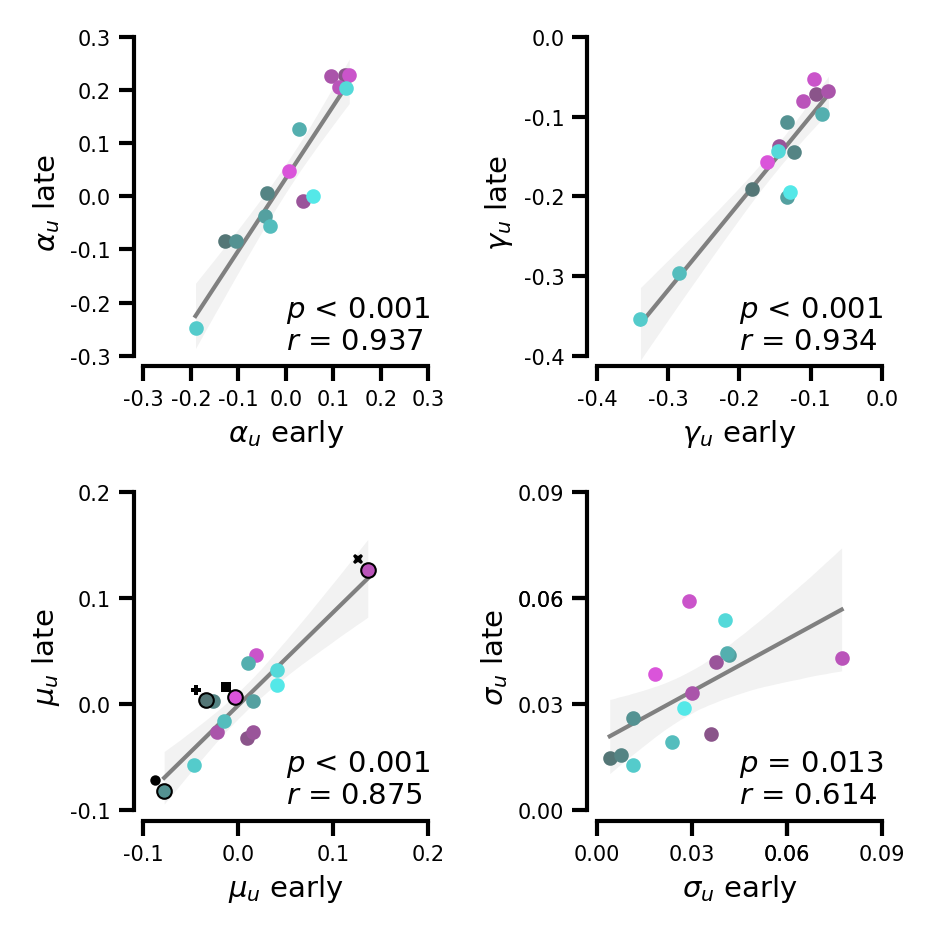

In [11]:
def FigureS4Atop(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    alpha_u_early = {animal: alpha_U[animal]["120"] for animal in animalList}
    alpha_u_late = {animal: alpha_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot(alpha_u_early[animal], alpha_u_late[animal], 
                color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, label=animal, zorder=4)

    ax.set_xlabel(r'$\alpha_u$' + ' early')
    ax.set_ylabel(r'$\alpha_u$' + ' late')
    ax.set_xlim(-0.3, 0.3)
    ax.set_xticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])
    ax.set_ylim(-0.3, 0.3)
    ax.set_yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3])

    early_late_regression(alpha_u_early, alpha_u_late, ax=ax)
    space_axes(ax)

def FigureS4Btop(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    gamma_u_early = {animal: gamma_U[animal]["120"] for animal in animalList}
    gamma_u_late = {animal: gamma_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot(gamma_u_early[animal], gamma_u_late[animal], 
                color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, label=animal, zorder=4)

    ax.set_xlabel(r'$\gamma_u$' + ' early')
    ax.set_ylabel(r'$\gamma_u$' + ' late')
    ax.set_xlim(-0.4, 0)
    ax.set_xticks([-0.4, -0.3, -0.2, -0.1, 0])
    ax.set_ylim(-0.4, 0)
    ax.set_yticks([-0.4, -0.3, -0.2, -0.1, 0])

    early_late_regression(gamma_u_early, gamma_u_late, ax=ax)
    space_axes(ax)

def FigureS9Atop(ax=None, exlist=[], symbols=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    mu_u_early = {animal: mu_U[animal]["120"] for animal in animalList}
    mu_u_late = {animal: mu_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        print(animal, mu_u_early[animal], mu_u_late[animal])
        if animal not in exlist:
            ax.plot(mu_u_early[animal], mu_u_late[animal], 
                    color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2.5, label=animal, zorder=4)

    shift = 0.01
    for animal, symb in zip(exlist, symbols):
        ax.plot(mu_u_early[animal]-shift, mu_u_late[animal]+shift, color='k', marker=symb, markersize=2.5, markeredgewidth=0)
        ax.plot(mu_u_early[animal], mu_u_late[animal], markeredgewidth=.5, markeredgecolor='k', zorder=10,
                    color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=3.5, label=animal)


    ax.set_xlabel(r'$\mu_u$' + ' early')
    ax.set_ylabel(r'$\mu_u$' + ' late')
    ax.set_xlim(-0.1, 0.2)
    ax.set_xticks([-0.1, 0, 0.1, 0.2])
    ax.set_ylim(-0.1, 0.2)
    ax.set_yticks([-0.1, 0, 0.1, 0.2])

    early_late_regression(mu_u_early, mu_u_late, ax=ax)
    space_axes(ax)

def FigureS9Btop(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sigma_u_early = {animal: sigma_U[animal]["120"] for animal in animalList}
    sigma_u_late = {animal: sigma_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot(sigma_u_early[animal], sigma_u_late[animal], 
                color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, label=animal, zorder=4)

    ax.set_xlabel(r'$\sigma_u$' + ' early')
    ax.set_ylabel(r'$\sigma_u$' + ' late')
    ax.set_xlim(0, 0.09)
    ax.set_xticks([0, 0.03, 0.06, 0.06, 0.09])
    ax.set_ylim(0, 0.09)
    ax.set_yticks([0, 0.03, 0.06, 0.06, 0.09])

    early_late_regression(sigma_u_early, sigma_u_late, ax=ax)
    space_axes(ax)

fig, axs = plt.subplots(2, 2, figsize=(3, 3))
FigureS4Atop(ax=axs[0, 0])
FigureS4Btop(ax=axs[0, 1])
FigureS9Atop(ax=axs[1, 0], exlist=['RatF32', 'RatM02', 'RatF42', 'RatM00'], symbols=['X', 'o', 's', 'P'])
FigureS9Btop(ax=axs[1, 1])

# Figure S4A, S4B, S9A, S9B bot comparison early/late

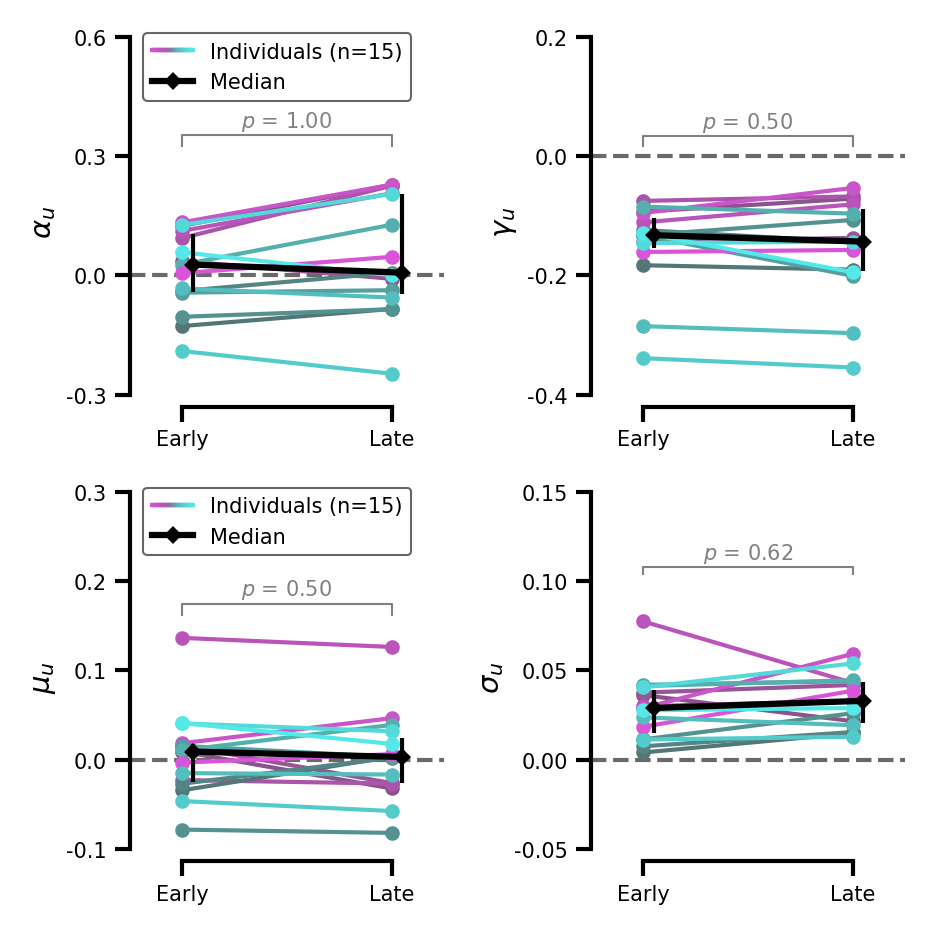

In [12]:
def FigureS4Abot(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    alpha_u_early = {animal: alpha_U[animal]["120"] for animal in animalList}
    alpha_u_late = {animal: alpha_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot([0, 1], [alpha_u_early[animal], alpha_u_late[animal]], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, zorder=4)

    perm = exact_mc_perm_paired_test(np.asarray(list(alpha_u_early.values())), np.asarray(list(alpha_u_late.values())))
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [0.3, 0.3], maxasterix=None)

    median_early = np.median(list(alpha_u_early.values()))
    top_early = np.percentile(list(alpha_u_early.values()), 75)
    bottom_early = np.percentile(list(alpha_u_early.values()), 25)
    median_late = np.median(list(alpha_u_late.values()))
    top_late = np.percentile(list(alpha_u_late.values()), 75)
    bottom_late = np.percentile(list(alpha_u_late.values()), 25)

    ax.errorbar([0.05, 1.05], [median_early, median_late],
                yerr=[[median_early - bottom_early, median_late - bottom_late], [top_early - median_early, top_late - median_late]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=100)

    ax.set_ylabel(r'$\alpha_u$')
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Early', 'Late'])
    ax.set_ylim(-0.3, 0.6)
    ax.set_yticks([-0.3, 0, 0.3, 0.6])
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    
    median = ax.plot([-110, -101], [-110, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label='Median')
    add_colored_intact(ax, handles=[median], labels=['Median'], text=f'Individuals (n={len(animalList)})', loc='lower left', bbox=(0.01, 0.8))
    space_axes(ax, x_ratio_left=0.25, x_ratio_right=0.25)

def FigureS4Bbot(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    gamma_u_early = {animal: gamma_U[animal]["120"] for animal in animalList}
    gamma_u_late = {animal: gamma_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot([0, 1], [gamma_u_early[animal], gamma_u_late[animal]], 
                color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, label=animal, zorder=4)

    perm = exact_mc_perm_paired_test(np.asarray(list(gamma_u_early.values())), np.asarray(list(gamma_u_late.values())))
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [0, 0], maxasterix=None)

    median_early = np.median(list(gamma_u_early.values()))
    top_early = np.percentile(list(gamma_u_early.values()), 75)
    bottom_early = np.percentile(list(gamma_u_early.values()), 25)
    median_late = np.median(list(gamma_u_late.values()))
    top_late = np.percentile(list(gamma_u_late.values()), 75)
    bottom_late = np.percentile(list(gamma_u_late.values()), 25)

    ax.errorbar([0.05, 1.05], [median_early, median_late],
                yerr=[[median_early - bottom_early, median_late - bottom_late], [top_early - median_early, top_late - median_late]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=100)

    ax.plot([-110, -101], [-110, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label='Median')

    ax.set_ylabel(r'$\gamma_u$')
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Early', 'Late'])
    ax.set_ylim(-0.4, 0.2)
    ax.set_yticks([-0.4, -0.2, 0, 0.2])
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=0.25, x_ratio_right=0.25)

def FigureS9Abot(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    mu_u_early = {animal: mu_U[animal]["120"] for animal in animalList}
    mu_u_late = {animal: mu_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot([0, 1], [mu_u_early[animal], mu_u_late[animal]], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, zorder=4)

    perm = exact_mc_perm_paired_test(np.asarray(list(mu_u_early.values())), np.asarray(list(mu_u_late.values())))
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [0.15, 0.15], maxasterix=None)

    median_early = np.median(list(mu_u_early.values()))
    top_early = np.percentile(list(mu_u_early.values()), 75)
    bottom_early = np.percentile(list(mu_u_early.values()), 25)
    median_late = np.median(list(mu_u_late.values()))
    top_late = np.percentile(list(mu_u_late.values()), 75)
    bottom_late = np.percentile(list(mu_u_late.values()), 25)

    ax.errorbar([0.05, 1.05], [median_early, median_late],
                yerr=[[median_early - bottom_early, median_late - bottom_late], [top_early - median_early, top_late - median_late]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=100)

    ax.set_ylabel(r'$\mu_u$')
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Early', 'Late'])
    ax.set_ylim(-0.1, 0.3)
    ax.set_yticks([-0.1, 0, 0.1, 0.2, 0.3])
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)

    median = ax.plot([-110, -101], [-110, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label='Median')
    add_colored_intact(ax, handles=[median], labels=['Median'], text=f'Individuals (n={len(animalList)})', loc='lower left', bbox=(0.01, 0.8))
    space_axes(ax, x_ratio_left=0.25, x_ratio_right=0.25)

def FigureS9Bbot(ax=None, exlist=[]):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sigma_u_early = {animal: sigma_U[animal]["120"] for animal in animalList}
    sigma_u_late = {animal: sigma_U_late[animal]["120"] for animal in animalList}

    for animal in animalList:
        ax.plot([0, 1], [sigma_u_early[animal], sigma_u_late[animal]], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2.5, zorder=4)

    perm = exact_mc_perm_paired_test(np.asarray(list(sigma_u_early.values())), np.asarray(list(sigma_u_late.values())))
    barplot_annotate_brackets(ax, 0, 1, perm, [0, 1], [0.1, 0.1], maxasterix=None)

    median_early = np.median(list(sigma_u_early.values()))
    top_early = np.percentile(list(sigma_u_early.values()), 75)
    bottom_early = np.percentile(list(sigma_u_early.values()), 25)
    median_late = np.median(list(sigma_u_late.values()))
    top_late = np.percentile(list(sigma_u_late.values()), 75)
    bottom_late = np.percentile(list(sigma_u_late.values()), 25)

    ax.errorbar([0.05, 1.05], [median_early, median_late],
                yerr=[[median_early - bottom_early, median_late - bottom_late], [top_early - median_early, top_late - median_late]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=100)

    ax.plot([-110, -101], [-110, -101], color='k', marker='D', markersize=2, linestyle='-', lw=1.5, label='Median')

    ax.set_ylabel(r'$\sigma_u$')
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Early', 'Late'])
    ax.set_ylim(-0.05, 0.15)
    ax.set_yticks([-0.05, 0, 0.05, 0.1, 0.15])
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, alpha=1, zorder=0)
    space_axes(ax, x_ratio_left=0.25, x_ratio_right=0.25)


fig, axs = plt.subplots(2, 2, figsize=(3, 3))
FigureS4Abot(ax=axs[0, 0])
FigureS4Bbot(ax=axs[0, 1])
FigureS9Abot(ax=axs[1, 0])
FigureS9Bbot(ax=axs[1, 1])

# Figure S4: Stability of decision-making parameters modulation by reward history (αu, γu)

Observed Slope: 1.3630
P-value: 0.0000
Observed Slope: 1.0912
P-value: 0.0000


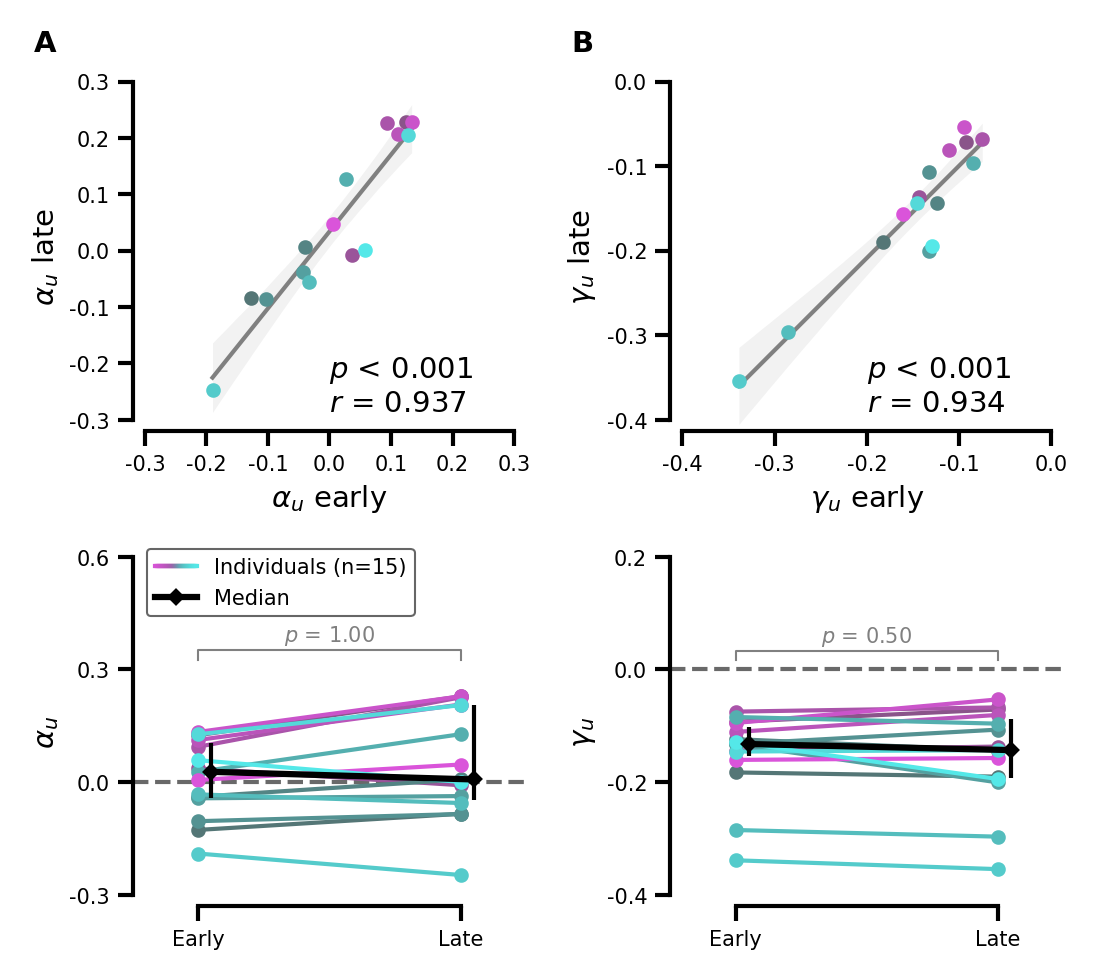

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(9), cm2inch(8)))
FigureS4Atop(ax=axs[0, 0])
FigureS4Btop(ax=axs[0, 1])
FigureS4Abot(ax=axs[1, 0])
FigureS4Bbot(ax=axs[1, 1])

for ax, letter in zip([axs[0, 0], axs[0, 1]], ["A", "B"]):
    old_letter_on_subplot(ax, letter, x_rel=-0.25, y_rel=1.15)

plt.savefig("./Figures_paper/Figure_S4.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_S4.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

# Figure S9C 4 example rats displaying distinct modulations of run duration by reward history

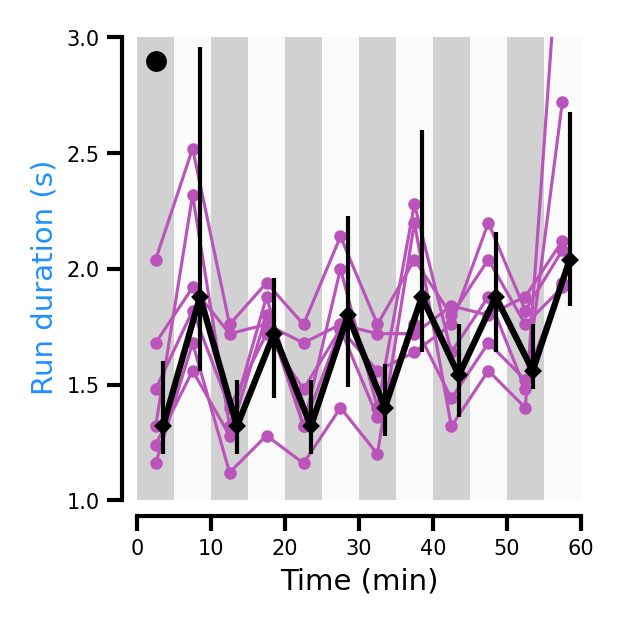

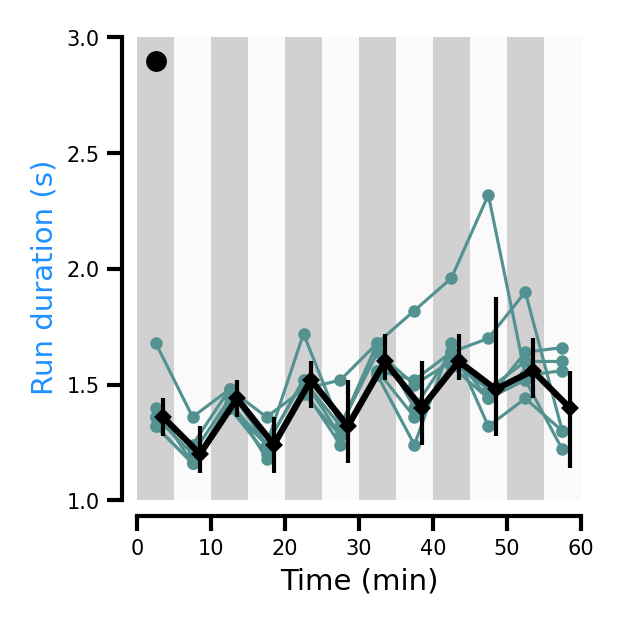

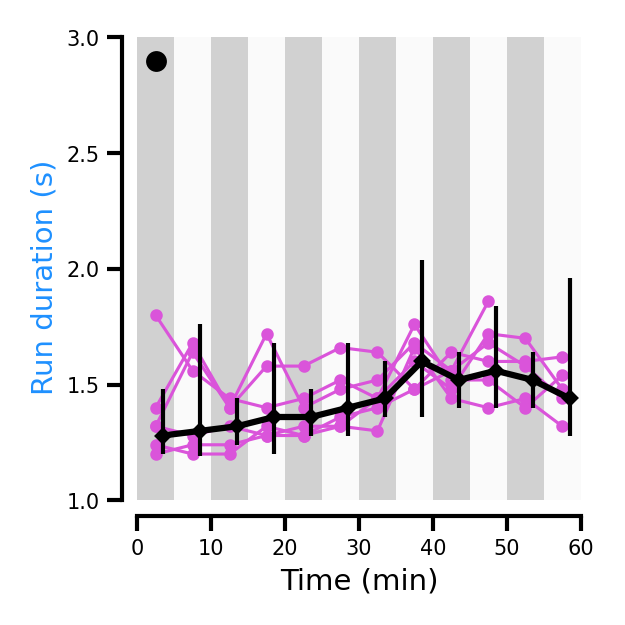

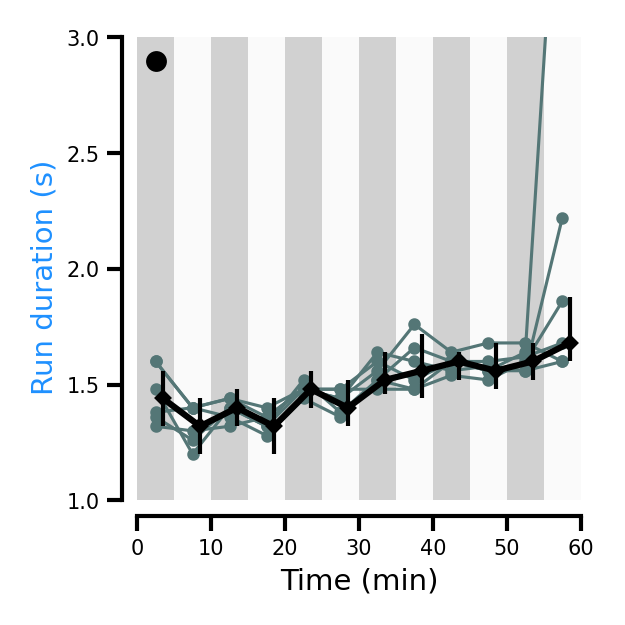

In [14]:
def separate_data(root, animal, session_list, run_or_idle="run"):

    def fix_singleRun(data):
        recoveredRun = []
        indexList = []
        fixedList = data.copy()
        for index, ele in enumerate(data):
            if not isinstance(ele, list):
                recoveredRun.append(np.float64(ele))
                indexList.append(index)
        if indexList:
            if indexList[0] != 0:
                fixedList = np.delete(fixedList, indexList[1:])
                fixedList[indexList[0]] = recoveredRun
            if indexList[0] == 0:
                fixedList = np.delete(fixedList, indexList)
                fixedList = np.append(fixedList, recoveredRun)
        return fixedList

    data = {bin: [] for bin in range(0, (12))}

    for session in sorted(matchsession(animal, session_list)):
        if run_or_idle == "run":
            dataLeft, dataRight = get_from_pickle(root, animal, session, name="timeRun.p")
        elif run_or_idle == "idle":
            dataLeft, dataRight = get_from_pickle(root, animal, session, name="timeinZone.p")
        for i in range(12):
            data[i] = np.append(data[i], [dataRight[i] + dataLeft[i]])
            data[i] = fix_singleRun(data[i])

    return data


def FigureS9C(root, animal='RatM00', symbol='o', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(5), cm2inch(5)))
    
    warnings.simplefilter("ignore", category=RuntimeWarning)
    sessionlist = dist120
    data = separate_data(root, animal, sessionlist, run_or_idle="run")

    for session in matchsession(animal, sessionlist):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        data_session = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]
        params = get_from_pickle(root, animal, session, name="params.p")
        blocks = params['blocks']
        rewardProbaBlock = params['rewardProbaBlock']

        session_data_medians = [np.nanmedian(data_session[i]) for i in range(12)]
        session_data_bot_percentiles = [np.nanpercentile(data_session[i], 25) for i in range(12)]
        session_data_top_percentiles = [np.nanpercentile(data_session[i], 75) for i in range(12)]
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                    session_data_medians,
                    marker='o', ms=2, color=rat_markers[animal][0], lw=.75, zorder=4)

    data_median = [np.nanmedian(data[i], axis=0) for i in range(0, len(blocks))]
    data_bot_percentiles = [np.nanpercentile(data[i], 25) for i in range(12)]
    data_top_percentiles = [np.nanpercentile(data[i], 75) for i in range(12)]
    ax.errorbar([1+(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
                data_median,
                yerr=[[data_median[i]-data_bot_percentiles[i] for i in range(12)],
                      [data_top_percentiles[i]-data_median[i] for i in range(12)]],
                capsize=0, color='k', marker='D', markersize=2, linestyle='-', lw=1.5, elinewidth=1, zorder=5)

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Run duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 3)
    ax.set_yticks([1, 1.5, 2, 2.5, 3])

    ax.plot(2.5, 2.9, color='k', marker=symbol, markersize=5, markeredgewidth=0)
    space_axes(ax)


for animal in ['RatF32', 'RatM02', 'RatF42', 'RatM00']:
    FigureS9C(root=root, animal=animal)

# Figure S9: Stability of model parameters capturing run duration modulation by reward history

RatF00 0.009107434957290972 -0.03208255255158913
RatF01 0.01573543240910998 -0.026141068536104928
RatF02 -0.02275976923419268 -0.026636438399740822
RatM00 -0.03416419882492632 0.003365036277151576
RatM01 -0.02683630069466536 0.0023120415983436103
RatM02 -0.07811677153615623 -0.08181052918085052
RatF32 0.1363040248918224 0.1261517901547261
RatF33 0.018478627853372374 0.04649801260225346
RatM31 0.015544416428895548 0.0031076465056710323
RatM32 0.010655624063402902 0.03893276311757711
RatF42 -0.00316511640391538 0.0062237311097746795
RatM40 -0.014965563789779594 -0.016532181843685052
RatM43 -0.04622975245793799 -0.05734652654438152
RatM53 0.04062845771079954 0.03194408454188878
RatM54 0.04104524028154054 0.01773548688734788
Observed Slope: 0.8756
P-value: 0.0001
Observed Slope: 0.4885
P-value: 0.0130


/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


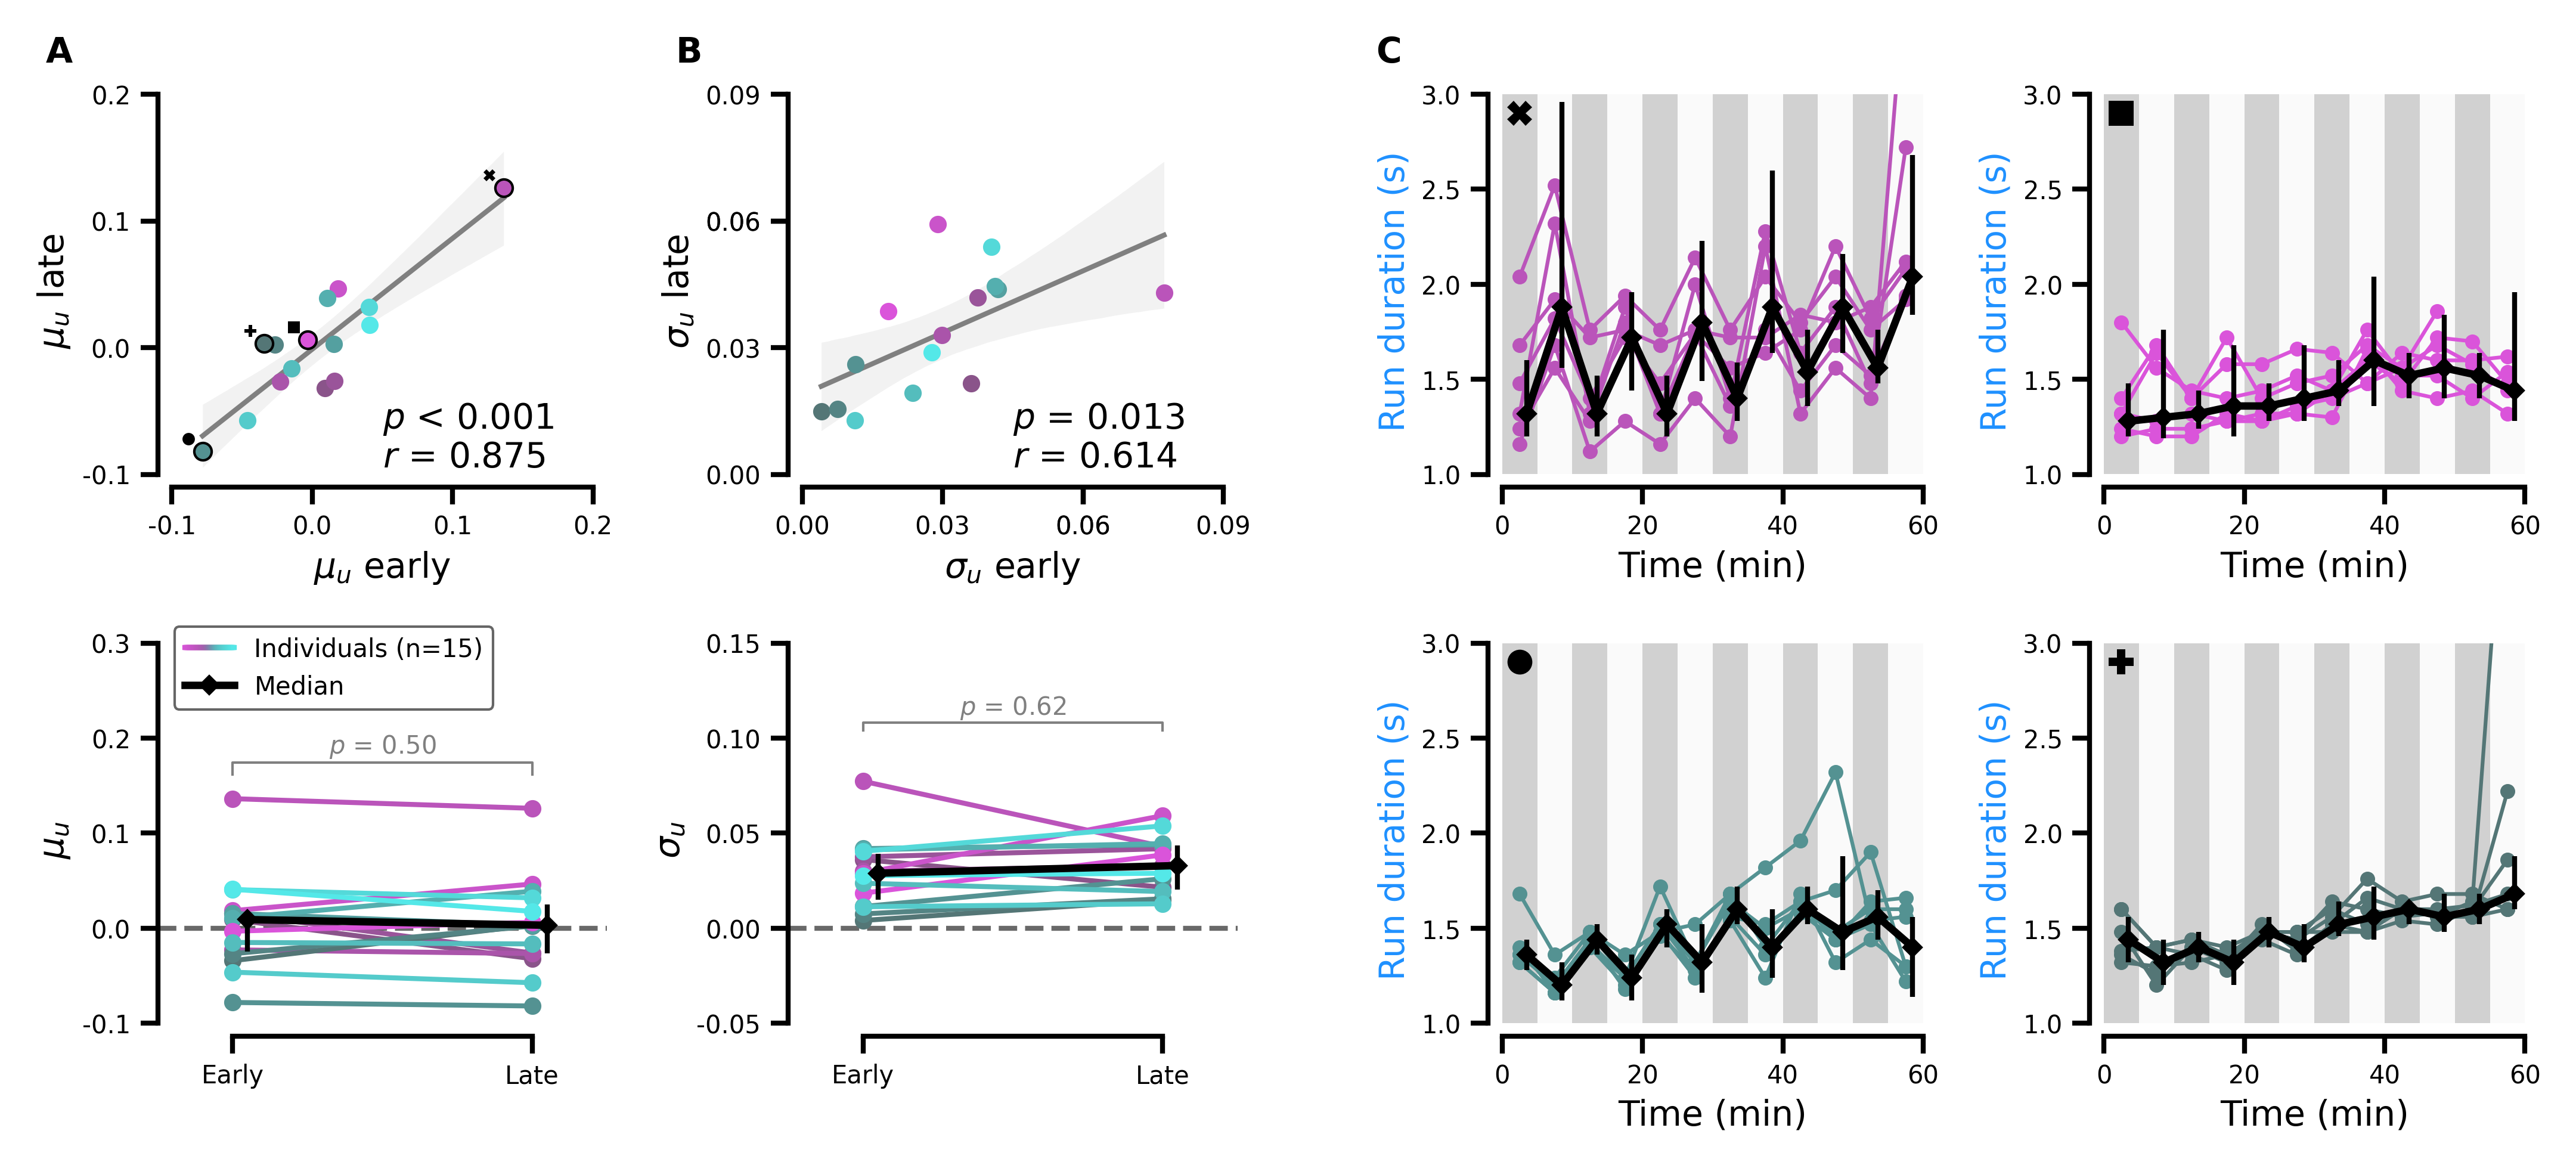

In [16]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(8)), 
               constrained_layout=True, facecolor='w', dpi=600)

gs = fig.add_gridspec(2, 5, height_ratios=[1, 1], width_ratios=[1, 1, .1, 1, 1])

FigureS9Atop(ax=plt.subplot(gs[0, 0]), exlist=['RatF32', 'RatM02', 'RatF42', 'RatM00'], symbols=['X', 'o', 's', 'P'])
FigureS9Btop(ax=plt.subplot(gs[0, 1]))
FigureS9Abot(ax=plt.subplot(gs[1, 0]))
FigureS9Bbot(ax=plt.subplot(gs[1, 1]))

FigureS9C(root, animal='RatF32', symbol='X', ax=plt.subplot(gs[0, 3]))
FigureS9C(root, animal='RatM02', symbol='o', ax=plt.subplot(gs[1, 3]))
FigureS9C(root, animal='RatF42', symbol='s', ax=plt.subplot(gs[0, 4]))
FigureS9C(root, animal='RatM00', symbol='P', ax=plt.subplot(gs[1, 4]))

for ax, letter in zip([plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 3])], ["A", "B", "C"]):
    old_letter_on_subplot(ax, letter, x_rel=-0.25, y_rel=1.15)

plt.savefig("./Figures_paper/Figure_S9.pdf", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_S9.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)